In [3]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
ExpMat = pd.read_csv("dat/Jon_data/energy-exp_level.csv", index_col="ROW", low_memory=False)
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene", low_memory=False)

### 0. Select Mutations for ASD & Sibling

In [6]:
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Rep_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Rep_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")
ASD_Rep_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Rep_Trios.txt", delimiter="\t")
AllMuts = pd.concat([ASD_Discov_Muts, ASD_Rep_Muts])
AllMuts = AllMuts.reset_index()

ASD_Discov_Proband = ASD_Discov_Trios[ASD_Discov_Trios["Pheno"]=="Affected"]["IID"].values
ASD_Rep_Proband = ASD_Rep_Trios[ASD_Rep_Trios["Pheno"]=="Affected"]["IID"].values

ASD_Discov_Sib = ASD_Discov_Trios[ASD_Discov_Trios["Pheno"]=="Unaffected"]["IID"].values
ASD_Rep_Sib = ASD_Rep_Trios[ASD_Rep_Trios["Pheno"]=="Unaffected"]["IID"].values

Combined_Probands = np.concatenate((ASD_Discov_Proband, ASD_Rep_Proband), axis=None)
Combined_siblings = np.concatenate((ASD_Discov_Sib, ASD_Rep_Sib), axis=None)
N_probands = Combined_Probands.shape[0]
N_siblings = Combined_siblings.shape[0]
print("N probands: %d\tN siblings: %d"%(N_probands, N_siblings))

AllProbandMuts = AllMuts[AllMuts["IID"].isin(Combined_Probands)]
AllSiblingMuts = AllMuts[AllMuts["IID"].isin(Combined_siblings)]

N probands: 23425	N siblings: 8267


In [14]:
# Select top ASD genes LGD/Dmis mutations
Spark_Meta = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/asd/spark_Meta_top_genes.xlsx")
HighConfGenes = Spark_Meta["HGNC"].values
Proband_HC = AllProbandMuts[AllProbandMuts["HGNC"].isin(HighConfGenes)]
Proband_HC_LGD_Dmis = Filt_LGD_Mis(Proband_HC, Dmis=True)
Proband_HC_LGD_Dmis.to_csv("dat/ASD_Proband_HC_LGD_Dmis.csv", index=False)

In [15]:
# Select Sibling genes LGD/Mis mutations
Sibling_LGD_Mis = Filt_LGD_Mis(AllSiblingMuts, Dmis=False)
Sibling_LGD_Mis.to_csv("dat/ASD_Sibling_LGD_Mis.csv", index=False)

In [75]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn

def Mut2GeneDF(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["HGNC"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        gene2MutN[Entrez] = N_LGD * w_LGD + N_Dmis * w_Dmis
    return gene2MutN

In [79]:
# ASD 
boot_gene2MutN = Mut2GeneDF(Proband_HC_LGD_Dmis, 0.537, 0.231)
ASD_Meta_Spec = AvgSTRZ_Weighted(ExpZscoreMat, boot_gene2MutN, 
                                 Method = 1, csv_fil = "dat/bias2/ASD_LGD_Dmis_avgz.bias.csv")

In [393]:
ASD_Meta_AvgZ2 = pd.read_csv("dat/bias2/ASD.Meta.avgZ.bias.csv", index_col="STR")

In [4]:
SparkMetaBias = pd.read_csv("dat/Jon_data/Spark_Final_ExpBias.csv")
SparkMetaBias.columns = ["STR", "EFFECT", "Rank", "NGene"]
SparkMetaBias = SparkMetaBias.set_index("STR")

### 1. Bootstrapped Bias

In [216]:
def CI(simulations, p):
    simulations = sorted(simulations, reverse=False)
    n = len(simulations)
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return(simulations[l_indx],simulations[u_indx])

class STRBias:
    def __init__(self, STR, Bias, Rank):
        self.STR = STR
        self.Bias = Bias
        self.Rank = Rank
        self.Boots = []
    def GetCI(self, p):
        return CI(self.Boots, p)

In [212]:
ASD_Boot_Dir = "dat/asd.boot.bias/asd.boot.avgz.{}.csv"
ASD_Bias_avgz = pd.read_csv("dat/bias2/ASD_LGD_Dmis_avgz.bias.csv", index_col="STR")
ASD_STR_Biases = {}
for STR, row in ASD_Bias_avgz.iterrows():
    ASD_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])
    
for i in np.arange(1,10001,1):
    df = pd.read_csv(ASD_Boot_Dir.format(i), index_col="STR")
    for STR, row in df.iterrows():
        ASD_STR_Biases[STR].Boots.append(row["EFFECT"])

In [89]:
Sib_Boot_Dir = "dat/asd.sib.boot.bias/sib.boot.avg.bias.{}.csv"
Sib_Bias_avgz = pd.read_csv("dat/bias2/ASD.Siblings.avgz.bias.csv", index_col="STR")
Sib_STR_Biases = {}
for STR, row in Sib_Bias_avgz.iterrows():
    Sib_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])
    
for i in np.arange(1,1001,1):
    df = pd.read_csv(Sib_Boot_Dir.format(i), index_col="STR")
    for STR, row in df.iterrows():
        Sib_STR_Biases[STR].Boots.append(row["EFFECT"])

In [194]:
##BGMR Bias
BGMR = pd.read_csv("/Users/jiayao/Work/Resources/MutationRate_20170711_rate.txt", delimiter="\t")
BGMR["Entrez"] = [int(GeneSymbol2Entrez.get(x, -1)) for x in BGMR["GeneName"].values]
BGMR = BGMR[BGMR["Entrez"].isin(allen_mouse_genes)]
BGMR.index=BGMR["Entrez"].values

bgmr_gene2Mut = {}
for entrez, row in BGMR.iterrows():
    bgmr_gene2Mut[entrez] = (row["p_LGD"] + row["prevel_0.5"]) * 1e6
    
BGMR_Meta_Spec = AvgSTRZ_Weighted(ExpZscoreMat, bgmr_gene2Mut, 
                                 Method = 1, csv_fil = "dat/bias2/BGMR_LGD_Dmis_avgz.bias.csv")
BGMR_Meta_Spec = BGMR_Meta_Spec.set_index("STR")

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,EFFECT,REGION,Rank
STR,,,
Lateral_septal_nucleus_ventral_part,0.092823,Striatum,1
Accessory_olfactory_bulb,0.085920,Olfactory_areas,2
Nucleus_incertus,0.083429,Pons,3
Posterior_limiting_nucleus_of_the_thalamus,0.083194,Thalamus,4
Central_linear_nucleus_raphe,0.080089,Midbrain,5
...,...,...,...
Paraflocculus,-0.086433,Cerebellum,209
Diagonal_band_nucleus,-0.094114,Pallidum,210
Primary_auditory_area,-0.117395,Isocortex,211


In [269]:
biases = []
for i in np.arange(1,10001,1):
    df = pd.read_csv(ASD_Boot_Dir.format(i), index_col="STR")
    biases.append(np.mean([abs(x) for x in df["EFFECT"].values]))

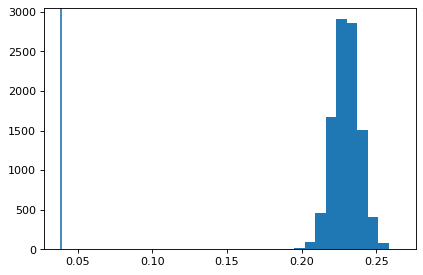

In [274]:
bias_bgmr = np.mean([abs(x) for x in BGMR_Meta_Spec["EFFECT"].values])
fig, ax = plt.subplots()
ax.hist(biases)
ax.axvline(x=bias_bgmr)

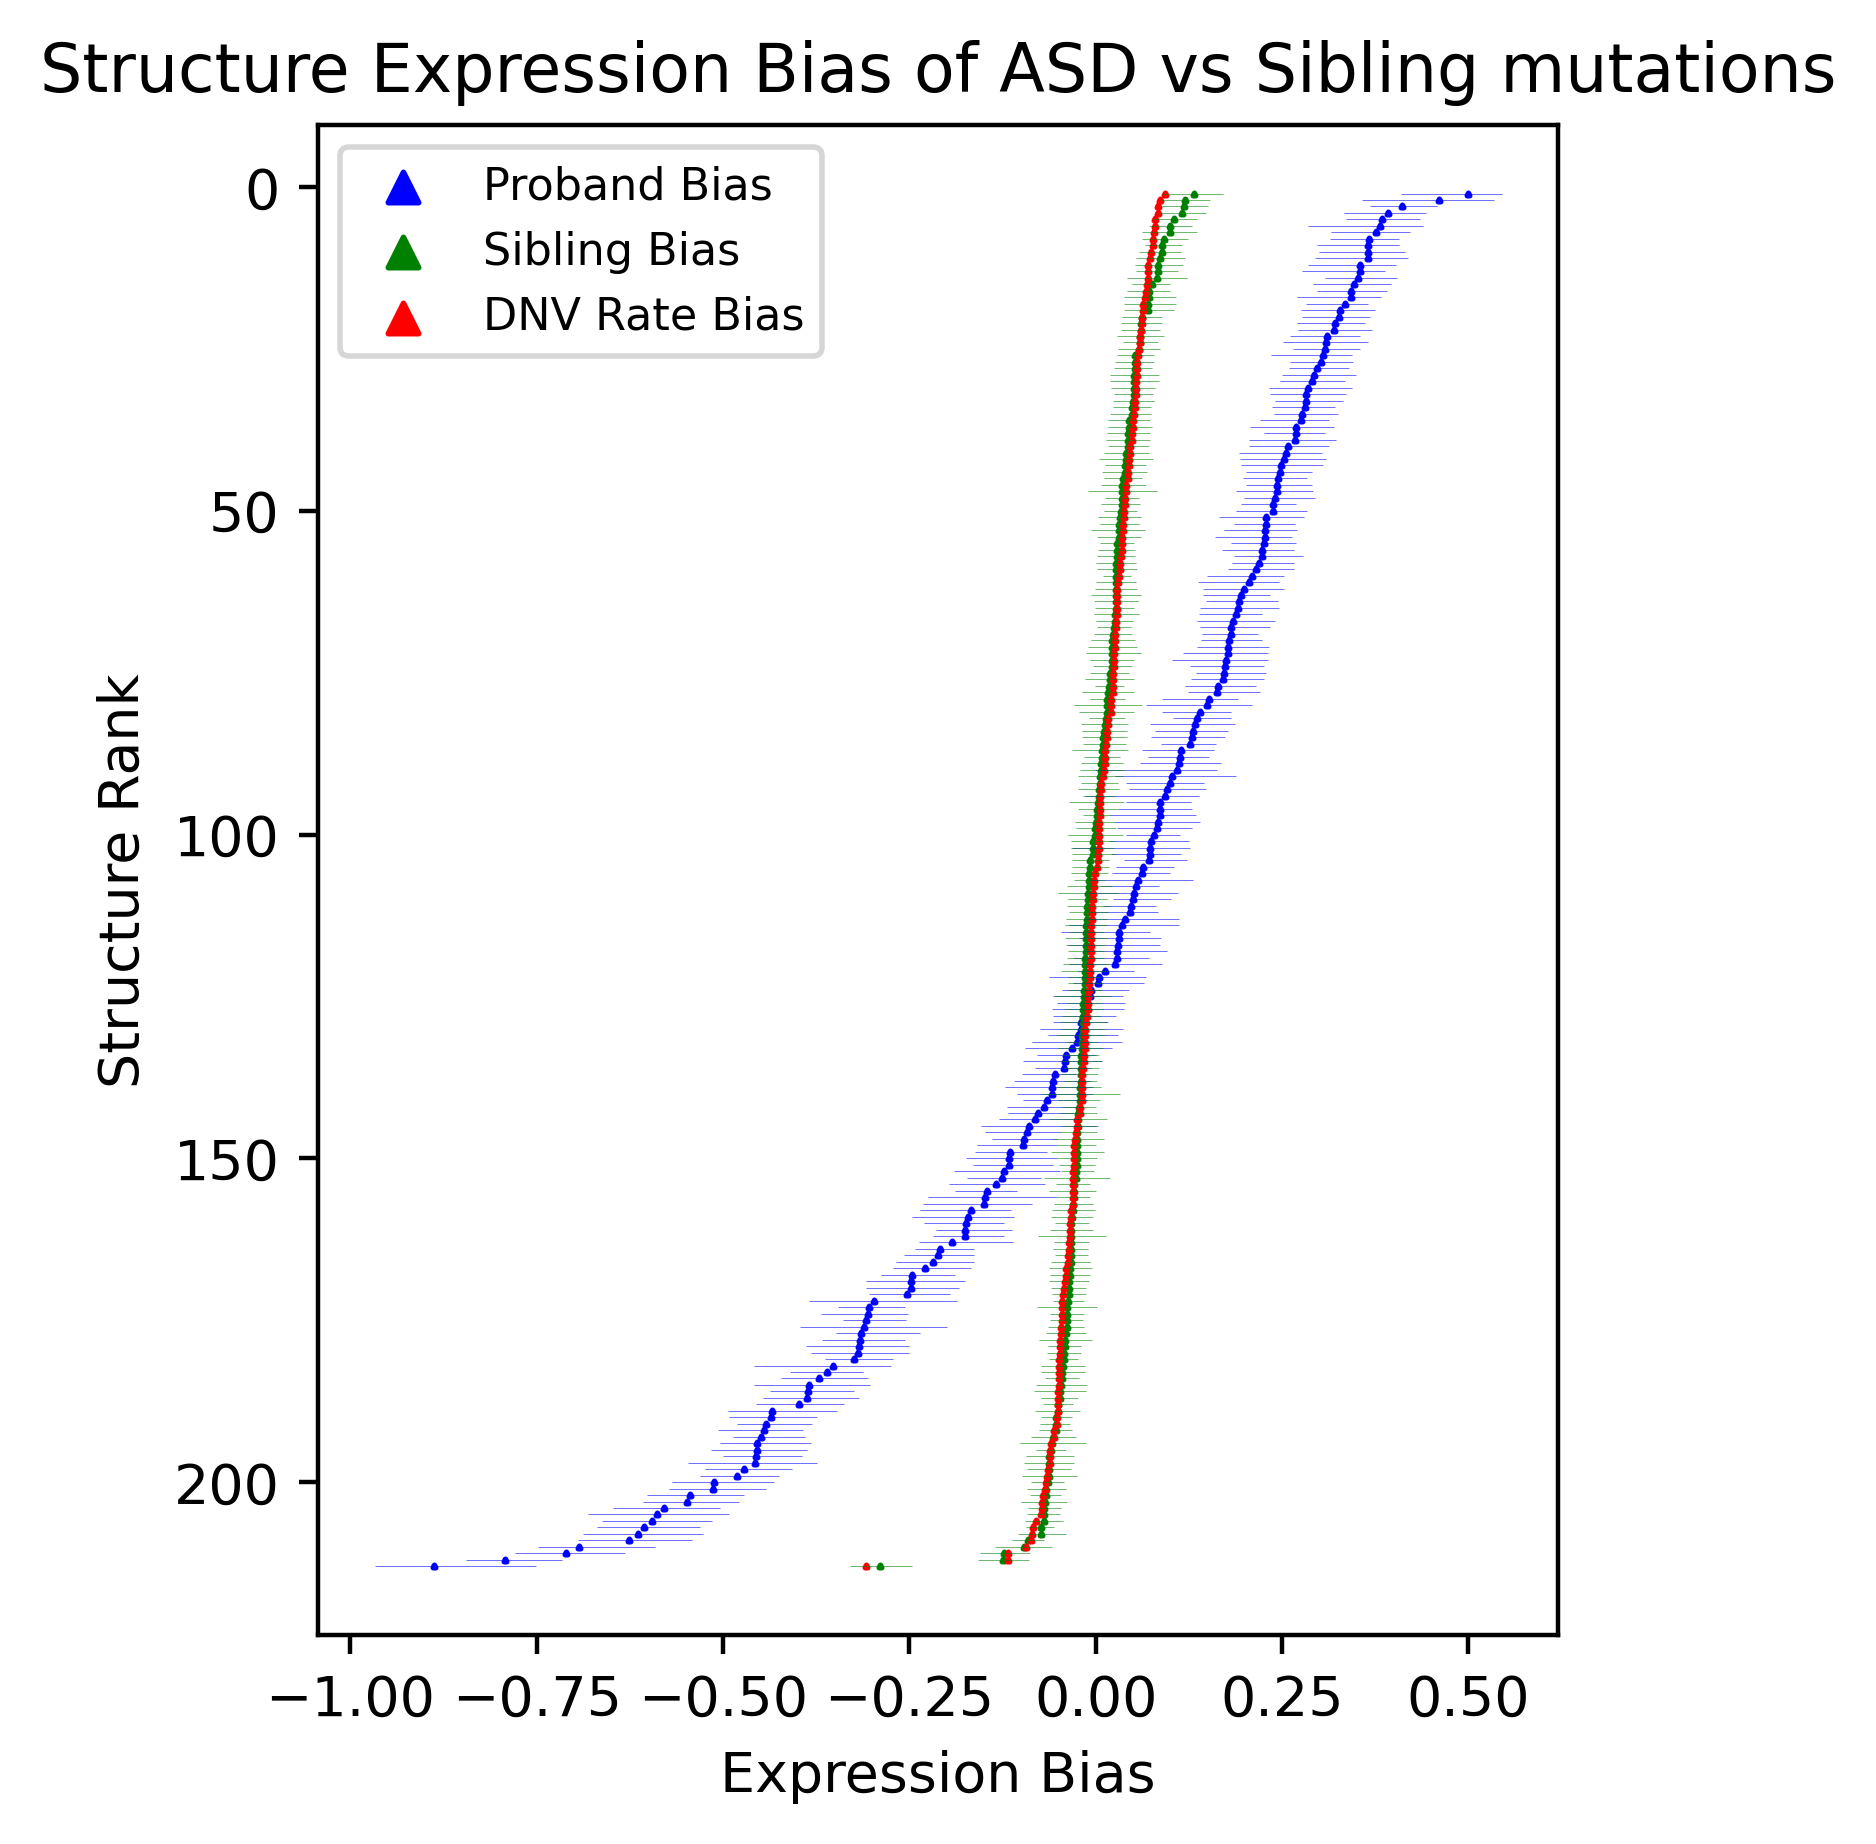

In [266]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=400)
for i, (STR, STR_bias) in enumerate(sorted(ASD_STR_Biases.items(), key=lambda x:x[1].Rank)):
    upper, lower = STR_bias.GetCI(0.95)
    ax.hlines(i+1, lower, upper, color = "blue", lw=0.1)
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="blue")
for i, (STR, STR_bias) in enumerate(sorted(Sib_STR_Biases.items(), key=lambda x:x[1].Rank)):
    upper, lower = STR_bias.GetCI(0.95)
    ax.hlines(i+1, lower, upper, color = "green", lw=0.1)
    x2 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="green")
    
x3 = ax.scatter(BGMR_Meta_Spec["EFFECT"].values, np.arange(1, 214, 1), color="red", s=0.2, marker="^")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2, x3], ["Proband Bias", "Sibling Bias", "DNV Rate Bias"], prop={'size': 8})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
plt.title("Structure Expression Bias of ASD vs Sibling mutations")
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.savefig("figs/ExpBias.pdf")

### 2. Bootstrapped top N Cohesiveness

In [394]:
g = LoadConnectome2()
EdgeWeightsDict = EdgeDict(g, keyon="label")

In [395]:
TopN_slice = list(range(20, 213, 5))

In [396]:
# ASD top N Cohe and boot
ASD_Cohesivness = []
for topN in TopN_slice:
    top_strs = ASD_Bias_avgz.head(topN).index.values
    ASD_Cohesivness.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    
ASD_Cohesivness_Boot = []
for i in range(1, 10001, 1):
    df = pd.read_csv(ASD_Boot_Dir.format(i), index_col="STR")
    topN_cohe = []
    for topN in TopN_slice:
        top_strs = df.head(topN).index.values
        topN_cohe.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    topN_cohe = np.array(topN_cohe)
    ASD_Cohesivness_Boot.append(topN_cohe)
ASD_Cohesivness_Boot = np.array(ASD_Cohesivness_Boot)

In [397]:
# Sib top N Cohe and boot
Sib_Cohesivness = []
for topN in TopN_slice:
    top_strs = Sib_Bias_avgz.head(topN).index.values
    Sib_Cohesivness.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    
Sib_Cohesivness_Boot = []
for i in range(1, 1001, 1):
    df = pd.read_csv(Sib_Boot_Dir.format(i), index_col="STR")
    topN_cohe = []
    for topN in TopN_slice:
        top_strs = df.head(topN).index.values
        topN_cohe.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])
    topN_cohe = np.array(topN_cohe)
    Sib_Cohesivness_Boot.append(topN_cohe)
Sib_Cohesivness_Boot = np.array(Sib_Cohesivness_Boot)

In [398]:
# WES De novo N Cohe and boot
BGMR_Cohesivness = []
for topN in TopN_slice:
    top_strs = BGMR_Meta_Spec.head(topN).index.values
    BGMR_Cohesivness.append(ScoreSTRSet(g, top_strs, EdgeWeightsDict)[0])

In [399]:
ASD_CohesivnessBoot.shape

(10000, 20)

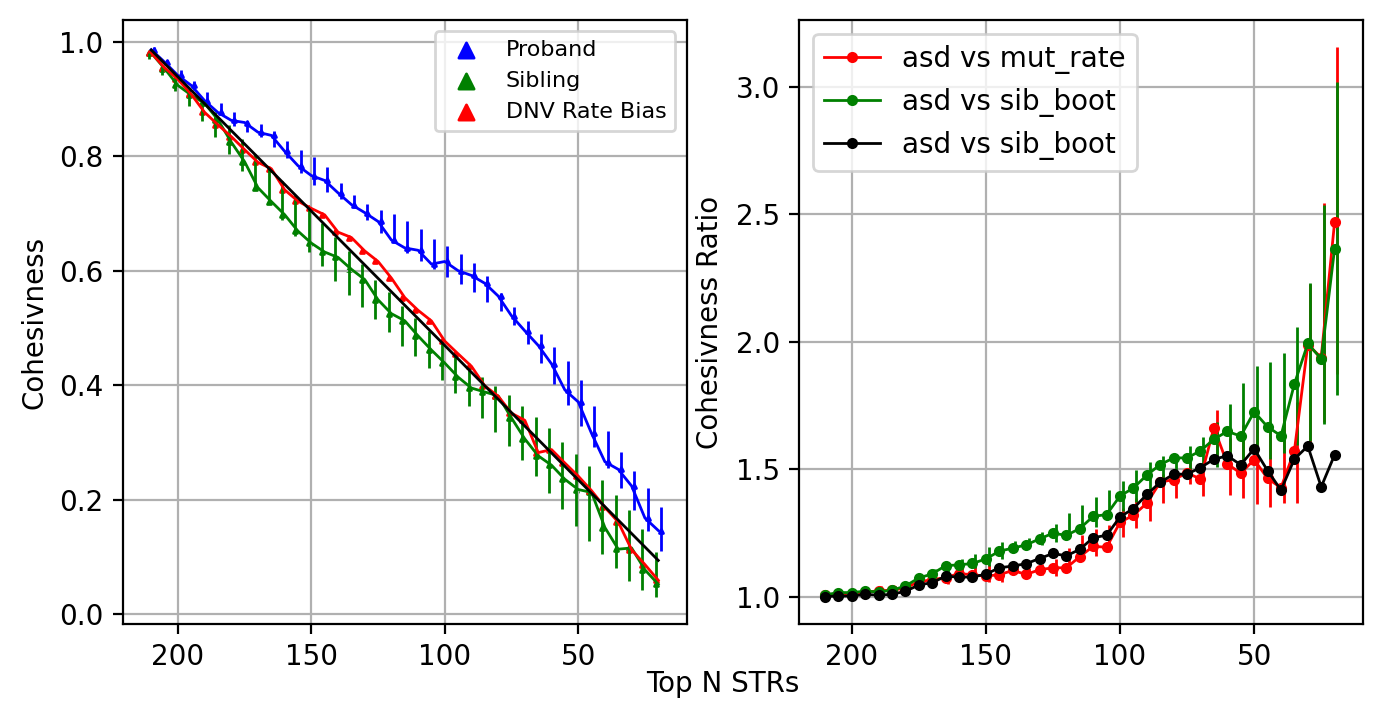

In [404]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=200)
for i, topN in enumerate(TopN_slice):
    values = ASD_Cohesivness_Boot[:, i]
    asd_lower, asd_upper = CI(np.array(values), 0.95)
    ax.vlines(topN-1, asd_lower, asd_upper, color = "blue", lw=1)
    x1 = ax.scatter(topN-1, ASD_Cohesivness[i], marker="^", s=2, color="blue")
    values2 = Sib_Cohesivness_Boot[:, i]
    lower, upper = CI(np.array(values2), 0.95)
    ax.vlines(topN+1, lower, upper, color = "green", lw=1)
    x2 = ax.scatter(topN+1, Sib_Cohesivness[i], marker="^", s=2, color="green")
    x3 = ax.scatter(topN+1, BGMR_Cohesivness[i], marker="^", s=2, color="red")
    
    ax2.vlines(topN-1, asd_lower/BGMR_Cohesivness[i], asd_upper/BGMR_Cohesivness[i], color = "red", lw=1)
    ax2.vlines(topN-1, asd_lower/np.mean(Sib_Cohesivness_Boot[:,i]), 
                       asd_upper/np.mean(Sib_Cohesivness_Boot[:,i]), color = "green", lw=1)
#ax.plot(TopN_slice, Sib_Cohesivness, color="green")
#ax.plot(TopN_slice, np.mean(Sib_Cohesivness_Boot, axis=0), color="green")
ax.plot(TopN_slice, ASD_Cohesivness, color="blue", lw=1)
ax.plot(TopN_slice, Sib_Cohesivness, color="green", lw=1)
ax.plot(TopN_slice, BGMR_Cohesivness, color="red", lw=1)
ax.plot(TopN_slice, np.array(TopN_slice)/213, color="black", lw=1)

ax2.plot(TopN_slice, np.array(ASD_Cohesivness)/np.array(BGMR_Cohesivness), 
        marker=".", lw=1, label="asd vs mut_rate", color='red')
ax2.plot(TopN_slice, np.array(ASD_Cohesivness)/np.mean(Sib_Cohesivness_Boot, axis=0), 
        marker=".", lw=1, label="asd vs sib_boot", color='green')
ax2.plot(TopN_slice, np.array(ASD_Cohesivness)/(np.array(TopN_slice)/213), 
        marker=".", lw=1, label="asd vs sib_boot", color='black')

lgnd = ax.legend([x1, x2, x3], ["Proband", "Sibling", "DNV Rate Bias"], prop={'size': 8})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]

ax2.legend(loc="upper left")
ax.invert_xaxis()
ax2.invert_xaxis()
ax.grid(True)
ax2.grid(True)

ax.set_ylabel("Cohesivness")
ax2.set_ylabel("Cohesivness Ratio")
fig.text(0.5, 0.04, 'Top N STRs', ha='center')
plt.savefig("figs/Boot_TopN_Cohesivness.pdf")

### 3. Circuit Search

In [7]:
# Load Connectome and Weights
adj_mat = pd.read_csv(ConnFil, index_col=0)
g = LoadConnectome2(adj_mat) # Load Connectiome
EdgeWeightsDict = EdgeDict(g, keyon="label")
str2reg = STR2Region()

adj_mat_Hippomask = pd.read_csv("../dat/allen-mouse-conn/adj_mat.hippo_mask.csv", index_col=0)
g_hippomask = LoadConnectome2(adj_mat_Hippomask)

InfoDict = pk.load(open("dat/EdgeDict_selfInfo.pk", 'rb'))
PlainDict = pk.load(open("dat/EdgeDict_Uniform.pk", 'rb'))

BGMR_Meta_Spec = pd.read_csv("dat/bias2/BGMR_LGD_Dmis_avgz.bias.csv", index_col="STR")

In [21]:
TopN_slice2 = np.arange(20, 100, 5)
ASD_N_left = []
ASD_Cohesivness_after_search = []
BGMR_Cohesivness_after_search = []
BGMR_N_left = []
for topN in TopN_slice2:
    CirSTRs, cohe, conn = GreedyTrim(SparkMetaBias, g, topN, PlainDict)
    ASD_N_left.append(len(CirSTRs))
    ASD_Cohesivness_after_search.append(cohe)
    CirSTRs, cohe, conn = GreedyTrim(BGMR_Meta_Spec, g, topN, PlainDict)
    BGMR_N_left.append(len(CirSTRs))
    BGMR_Cohesivness_after_search.append(cohe)

In [22]:
CirSTRs, cohe, conn = GreedyTrim(SparkMetaBias, g, 50, PlainDict)
RegionDistributionsList(CirSTRs)

Cortical_subplate 	 3 	 Basolateral_amygdalar_nucleus; Claustrum; Endopiriform_nucleus_dorsal_part
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Submedial_nucleus_of_the_thalamus
Hippocampal_region 	 4 	 Field_CA1; Field_CA2; Field_CA3; Dentate_gyrus
Striatum 	 3 	 Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_caudal_caudodorsal_part
Hippocampal_formation 	 1 	 Subiculum_dorsal_part
Isocortex 	 19 	 Anterior_cingulate_area_dorsal_part; Anterior_cingulate_area_ventral_part; Agranular_insular_area_posterior_part; Agranular_insular_area_ventral_part; Frontal_pole_cerebral_cortex; Gustatory_areas; Infralimbic_area; Primary_motor_area; Secondary_motor_area; Orbital_area_lateral_part; Orbital_area_medial_part; Orbital_area_ventrolateral_part; Prelimbic_area; Posterior_parietal_association_areas; Retrosplenial_area_lateral_agranular_part; Visceral_area; Anteromedial_visual_area; Lateral_visual_

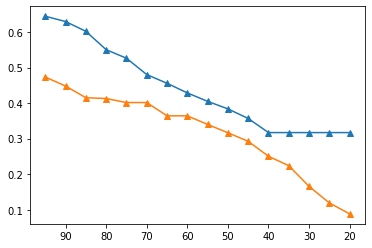

In [23]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search), marker="^")
ax.plot(TopN_slice2, BGMR_Cohesivness_after_search, marker="^")
ax.invert_xaxis()

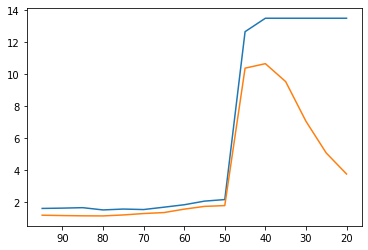

In [24]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search)/np.array([x/213 for x in ASD_N_left]))
ax.plot(TopN_slice2, np.array(BGMR_Cohesivness_after_search)/np.array([x/213 for x in ASD_N_left]))
ax.invert_xaxis()
#ax.set_ylim((0,5))

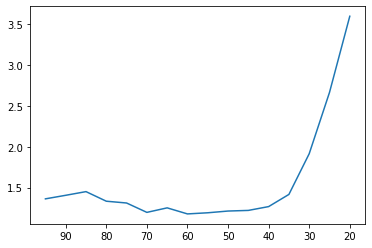

In [25]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search)/np.array(BGMR_Cohesivness_after_search))
#ax.plot(TopN_slice2, BGMR_Cohesivness)
ax.invert_xaxis()

In [26]:
TopN_slice2 = np.arange(20, 100, 5)
ASD_N_left_after_search = []
ASD_Cohesivness_after_search_hippomask = []
BGMR_Cohesivness_after_search_hippomask = []
BGMR_N_left_after_search = []
for topN in TopN_slice2:
    CirSTRs, cohe, conn = GreedyTrim(SparkMetaBias, g_hippomask, topN, PlainDict)
    ASD_N_left_after_search.append(len(CirSTRs))
    ASD_Cohesivness_after_search_hippomask.append(cohe)
    CirSTRs, cohe, conn = GreedyTrim(BGMR_Meta_Spec, g_hippomask, topN, PlainDict)
    BGMR_N_left_after_search.append(len(CirSTRs))
    BGMR_Cohesivness_after_search_hippomask.append(cohe)

Cortical_subplate 	 2 	 Claustrum; Endopiriform_nucleus_dorsal_part
Thalamus 	 1 	 Lateral_posterior_nucleus_of_the_thalamus
Hippocampal_region 	 2 	 Field_CA1; Field_CA2
Striatum 	 1 	 Nucleus_accumbens
Hippocampal_formation 	 2 	 Subiculum_dorsal_part; Subiculum_ventral_part
Isocortex 	 9 	 Anterior_cingulate_area_dorsal_part; Agranular_insular_area_ventral_part; Infralimbic_area; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Prelimbic_area; Retrosplenial_area_lateral_agranular_part; Anteromedial_visual_area; Primary_visual_area
Olfactory_areas 	 3 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Dorsal_peduncular_area


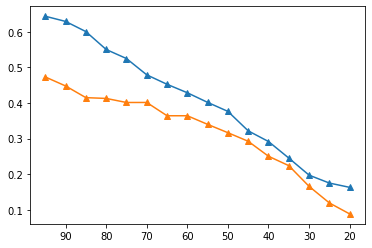

In [29]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search_hippomask), marker="^")
ax.plot(TopN_slice2, BGMR_Cohesivness_after_search_hippomask, marker="^")
ax.invert_xaxis()

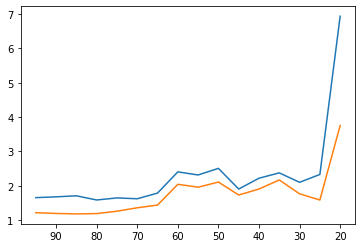

In [30]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search_hippomask)/np.array([x/213 for x in ASD_N_left_after_search]))
ax.plot(TopN_slice2, np.array(BGMR_Cohesivness_after_search_hippomask)/np.array([x/213 for x in ASD_N_left_after_search]))
ax.invert_xaxis()
#ax.set_ylim((0,5))

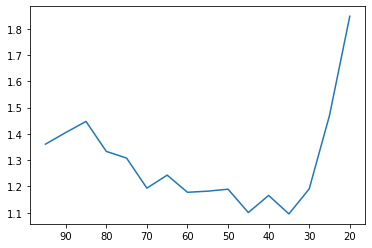

In [31]:
fig, ax = plt.subplots()
ax.plot(TopN_slice2, np.array(ASD_Cohesivness_after_search_hippomask)/np.array(BGMR_Cohesivness_after_search_hippomask))
#ax.plot(TopN_slice2, BGMR_Cohesivness)
ax.invert_xaxis()

In [33]:
CirSTRs, cohe, conn = GreedyTrim(SparkMetaBias, g_hippomask, 20, PlainDict)
RegionDistributionsList(CirSTRs)

Hippocampal_region 	 3 	 Field_CA1; Field_CA2; Field_CA3
Hippocampal_formation 	 2 	 Subiculum_dorsal_part; Subiculum_ventral_part
